<a href="https://colab.research.google.com/github/robitussin/CCDEPLRL/blob/main/Ensemble_CNN%2BGRU(mental_health_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import random
import string
from nltk.corpus import stopwords 
from string import punctuation
import time

%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False

nltk.download('stopwords')
from nltk.corpus import stopwords

from tensorflow.keras.utils import plot_model
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.layers import Input, Embedding, Conv1D, Dropout, MaxPool1D, Flatten, Dense, Bidirectional, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  from ipykernel import kernelapp as app
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train_url = "https://github.com/robitussin/mental-illness/blob/4719afa5e9c628e8acd9f4f4d424de74a0481bdb/trainingset.csv?raw=true"
validation_url = "https://github.com/robitussin/mental-illness/blob/4719afa5e9c628e8acd9f4f4d424de74a0481bdb/validationset.csv?raw=true"
test_url = "https://github.com/robitussin/mental-illness/blob/d0092e117d751024aafc5e6b5c2f2db125b7701c/testset.csv?raw=true"

train_corpus = pd.read_csv(train_url)
validation_corpus  = pd.read_csv(validation_url) 
test_corpus = pd.read_csv(test_url)

print(train_corpus.shape)
print(validation_corpus.shape)
print(test_corpus.shape)

(13727, 5)
(1488, 5)
(1488, 5)


In [ ]:
train_corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13727 entries, 0 to 13726
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          13727 non-null  object
 1   title       13727 non-null  object
 2   post        13727 non-null  object
 3   class_name  13727 non-null  object
 4   class_id    13727 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 536.3+ KB


In [ ]:
validation_corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1488 entries, 0 to 1487
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          1488 non-null   object
 1   title       1488 non-null   object
 2   post        1488 non-null   object
 3   class_name  1488 non-null   object
 4   class_id    1488 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 58.2+ KB


In [ ]:
test_corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1488 entries, 0 to 1487
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          1488 non-null   object
 1   title       1488 non-null   object
 2   post        1488 non-null   object
 3   class_name  1488 non-null   object
 4   class_id    1488 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 58.2+ KB


In [ ]:
train_corpus = train_corpus.dropna().reset_index(drop=True)

In [ ]:
train_corpus.drop_duplicates(inplace = True)

In [ ]:
train_corpus['post'] = train_corpus['title'] + " " + train_corpus['post']

In [ ]:
def replaceemail(post):
  regex = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
  noemail = re.sub(regex, "", post)
  return noemail

In [ ]:
train_corpus["post"] = train_corpus["post"].apply(replaceemail)

In [ ]:
stop_words = set(stopwords.words('english'))

def clean(input_string):
    """ Remove html line-break tags and handle punctuation """
    no_uppercased = input_string.lower()
    no_stars = re.sub("\*",  " ", no_uppercased)
    no_html = re.sub("<br />",  "", no_stars)
    no_digits = re.sub("\w*\d\w*",  "", no_html)
    no_punctuations = re.sub(f"([{string.punctuation}])", r" ", no_digits)

    #remove stop words
    no_stop_words = ' '+no_punctuations+ ' '
    for each in stop_words:
      no_stop_words = re.sub(' '+each[0]+' ', r" ", no_stop_words)
    no_extra_space = re.sub(" +", " ", no_stop_words)

    return no_extra_space

In [ ]:
train_corpus["post"] = train_corpus["post"].apply(clean)

In [ ]:
# Separate the sentences and the labels
# Separate the sentences and the labels for training and testing
train_x = list(train_corpus.post)
train_y = np.array(train_corpus.class_id)
print(len(train_x))
print(len(train_y))

val_x = list(validation_corpus.post)
val_y = np.array(validation_corpus.class_id)
print(len(val_x))
print(len(val_y))

test_x = list(test_corpus.post)
test_y = np.array(test_corpus.class_id)

13727
13727
1488
1488


In [ ]:
# Define a function to compute the max length of sequence
def max_length(sequences):
    '''
    input:
        sequences: a 2D list of integer sequences
    output:
        max_length: the max length of the sequences
    '''
    max_length = 0
    for i, seq in enumerate(sequences):
        length = len(seq)
        if max_length < length:
            max_length = length
    return max_length

In [ ]:
trunc_type='post'
padding_type='post'
oov_tok = "<UNK>"

# Separate the sentences and the labels
train_x = list(train_corpus.post)
train_y = np.array(train_corpus.class_id)
val_x = list(validation_corpus.post)
val_y = np.array(validation_corpus.class_id)
test_x = list(test_corpus.post)
test_y = np.array(test_corpus.class_id)


# Cleaning and Tokenization
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(train_x)

print("Example of sentence: ", train_x[4])

# Turn the text into sequence
training_sequences = tokenizer.texts_to_sequences(train_x)
max_len = max_length(training_sequences)

print('Into a sequence of int:', training_sequences[4])

# Pad the sequence to have the same size
training_padded = pad_sequences(training_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)
print('Into a padded sequence:', training_padded[4])

Example of sentence:   science ama series i’m phil baran and i’m here to talk about our work at the baran laboratory where we try to simplify the way molecules are created i’m also macarthur fellow “genius grant recipient” ama i’m phil baran and teach organic chemistry at the scripps research institute also head the baran laboratory vibrant and passionate team of graduate students and postdoctoral scholars vigorously trying to uncover chemistry’s many hidden secrets in the pursuit of useful reactions that can simplify the way molecules are created in the lab in nutshell we like to pursue problems whose solution can have rapid impact in areas that are important to modern society such as the invention of new pharmaceuticals agrochemicals or materials our general philosophy to making complex molecules in the laboratory has been summarized in multiple locations but suffice it to say we are aiming for syntheses that are as close to “ideal” as possible with regards to inventing methodologies

In [ ]:
# See the first 10 words in the vocabulary

word_index = tokenizer.word_index
for i, word in enumerate(word_index):
    print(word, word_index.get(word))
    if i==9:
        break
vocab_size = len(word_index)+1
print(vocab_size)

<UNK> 1
to 2
and 3
the 4
my 5
of 6
it 7
that 8
in 9
me 10
44781


In [ ]:
def define_model(filters = 100, kernel_size = 3, activation='relu', input_dim = None, output_dim=300, max_length = None ):
  
    # Channel 1
    input1 = Input(shape=(max_length,))
    embeddding1 = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=max_length)(input1)
    conv1 = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', 
                   kernel_constraint= MaxNorm( max_value=3, axis=[0,1]))(embeddding1)
    pool1 = MaxPool1D(pool_size=2, strides=2)(conv1)
    flat1 = Flatten()(pool1)
    drop1 = Dropout(0.5)(flat1)
    dense1 = Dense(10, activation='relu')(drop1)
    drop1 = Dropout(0.5)(dense1)
    out1 = Dense(units=6, activation='softmax')(drop1)
    
    # Channel 2
    input2 = Input(shape=(max_length,))
    embeddding2 = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=max_length, mask_zero=True)(input2)
    gru2 = Bidirectional(GRU(64))(embeddding2)
    drop2 = Dropout(0.5)(gru2)
    out2 = Dense(units=6, activation='softmax')(drop2)
    
    # Merge
    merged = concatenate([out1, out2])
    
    # Interpretation
    outputs = Dense(units=6, activation='softmax')(merged)
    model = Model(inputs=[input1, input2], outputs=outputs)
    
    # Compile
    model.compile( loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [ ]:
model_0 = define_model( input_dim=1000, max_length=100)
model_0.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 300)     300000      ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 98, 100)      90100       ['embedding[0][0]']              
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 49, 100)      0           ['conv1d[0][0]']                 
                                                                                              

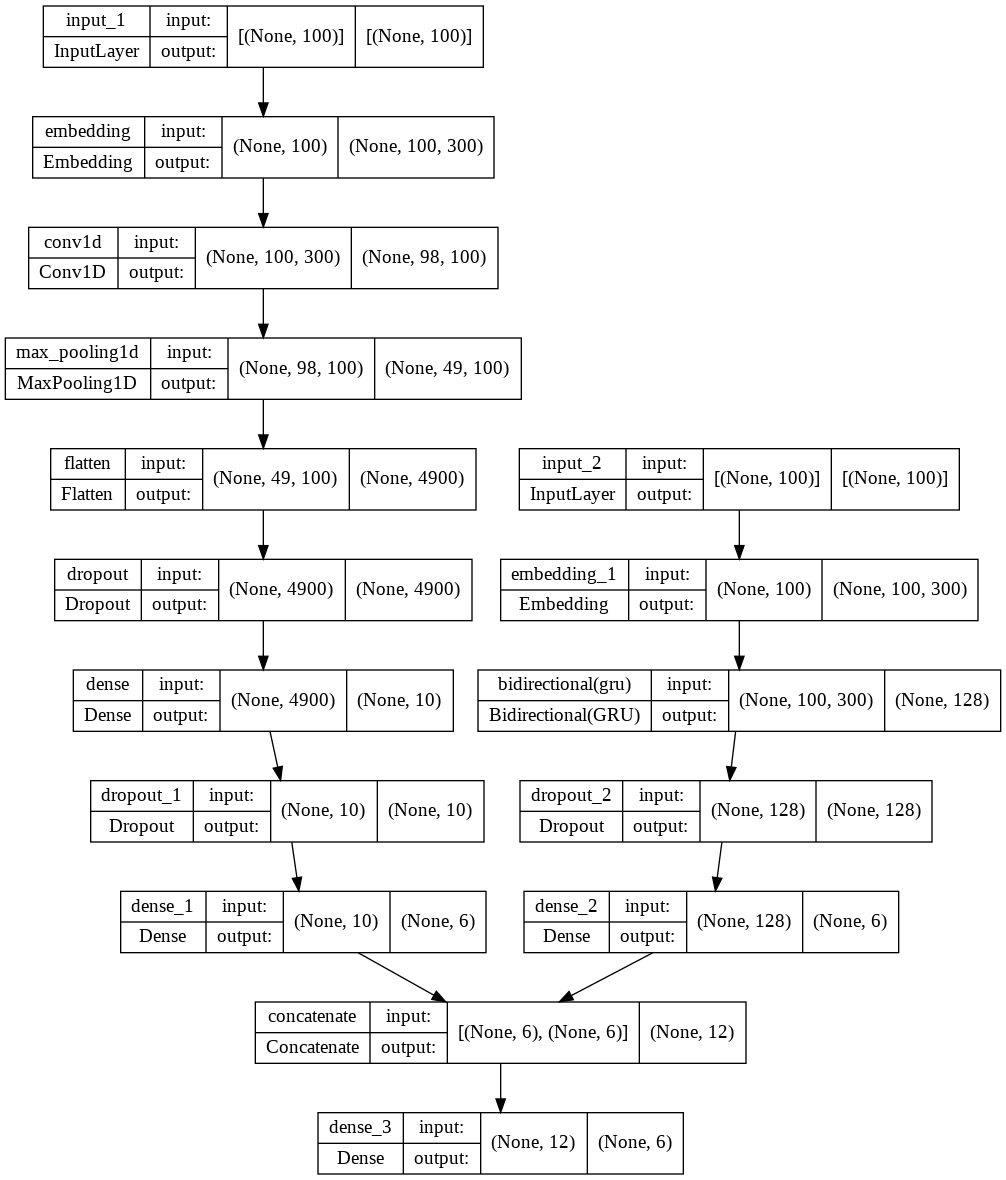

In [ ]:

tf.keras.utils.plot_model(model_0, show_shapes=True)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    # Overide the method on_epoch_end() for our benefit
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.93):
            print("\nReached 93% accuracy so cancelling training!")
            self.model.stop_training=True


callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, 
                                             patience=20, verbose=2, 
                                             mode='auto', restore_best_weights=True)

In [ ]:
# Parameter Initialization
trunc_type='post'
padding_type='post'
oov_tok = "<UNK>"
activations = ['relu']
filters = 100
#kernel_sizes = [1, 2, 3, 4, 5, 6]
kernel_sizes = [1]
columns = ['Activation', 'Filters', 'Acc']
record = pd.DataFrame(columns = columns)

# Separate the sentences and the labels
train_x = list(train_corpus.post)
train_y = np.array(train_corpus.class_id)
val_x = list(validation_corpus.post)
val_y = np.array(validation_corpus.class_id)
test_x = list(test_corpus.post)
test_y = np.array(test_corpus.class_id)

for activation in activations:

    for kernel_size in kernel_sizes:

        # encode data using
        # Cleaning and Tokenization
        tokenizer = Tokenizer(oov_token=oov_tok)
        tokenizer.fit_on_texts(train_x)

        # Turn the text into sequence
        training_sequences = tokenizer.texts_to_sequences(train_x)
        val_sequences = tokenizer.texts_to_sequences(val_x)
        test_sequences = tokenizer.texts_to_sequences(test_x)

        max_len = max_length(training_sequences)

        # Pad the sequence to have the same size
        Xtrain = pad_sequences(training_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)
        Xval = pad_sequences(val_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)
        Xtest = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

        word_index = tokenizer.word_index
        vocab_size = len(word_index)+1

        # Define the model
        model = define_model(filters, kernel_size, activation, input_dim=vocab_size, max_length=max_len)

        # Train the model
        acc = 0 
        while (acc<0.65):
            
            model.fit([Xtrain, Xtrain], train_y, batch_size=50, epochs=100, verbose=1, 
                      callbacks=[callbacks], validation_data=([Xval, Xval], val_y))
            
            loss, acc = model.evaluate([Xval, Xval], val_y, verbose=0)
            
            if (acc<0.55):
                # Re-define the model
                model = define_model(filters, kernel_size, activation, input_dim=vocab_size, max_length=max_len)
                print('The model is suffered from optimizing the local minimum :(')
                
            else:
                print('Done!')

        # evaluate the model
        loss, acc = model.evaluate([Xval, Xval], val_y, verbose=0)
        print('Test Accuracy: {}'.format(acc*100))

        parameters = [activation, kernel_size]
        entries = parameters + [acc]

        temp = pd.DataFrame([entries], columns=columns)
        record = record.append(temp, ignore_index=True)
        print()
        print(record)
        print()

Epoch 1/100
275/275 [==============================] - 82s 229ms/step - loss: 1.6168 - accuracy: 0.3492 - val_loss: 1.3977 - val_accuracy: 0.5578
Epoch 2/100
275/275 [==============================] - 60s 217ms/step - loss: 1.2363 - accuracy: 0.6261 - val_loss: 1.1898 - val_accuracy: 0.6008
Epoch 3/100
275/275 [==============================] - 59s 216ms/step - loss: 1.0129 - accuracy: 0.6707 - val_loss: 1.1069 - val_accuracy: 0.6082
Epoch 4/100
275/275 [==============================] - 59s 216ms/step - loss: 0.8242 - accuracy: 0.7216 - val_loss: 1.0670 - val_accuracy: 0.5927
Epoch 5/100
275/275 [==============================] - 60s 218ms/step - loss: 0.7055 - accuracy: 0.7493 - val_loss: 1.1580 - val_accuracy: 0.5827
Epoch 6/100
275/275 [==============================] - 60s 219ms/step - loss: 0.6280 - accuracy: 0.7653 - val_loss: 1.1410 - val_accuracy: 0.5813
Epoch 7/100
275/275 [==============================] - 60s 217ms/step - loss: 0.5705 - accuracy: 0.7823 - val_loss: 1.2036 -

In [ ]:
test_prob = model.predict([Xtest, Xtest], verbose=0)

In [ ]:
test_pred = np.argmax(test_prob, axis=1)

In [ ]:
test_pred.shape

In [ ]:
accuracy = accuracy_score(test_y, test_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_y, test_pred, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_y, test_pred, average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_y, test_pred, average='macro')
print('F1 score: %f' % f1)